In [1]:
import pandas as pd
import yaml
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from modeling import update_config

In [3]:
rusher_stat_cols =[
 'carries_roll',
 'rushing_yards_roll',
 'rushing_tds_roll',
 'rushing_first_downs_roll',
 #'receiving_yards_roll',
 #'receiving_tds_roll',
 'fantasy_points_ppr_roll',
 'yards_per_carry_roll']

In [4]:
team = pd.read_csv('data/agg/team_stats.csv', index_col=0)
opp = pd.read_csv('data/agg/opp_stats.csv', index_col=0)
team_stat_cols = [
 'completions_team_roll',
 'attempts_team_roll',
 'carries_team_roll',
 'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'completions_opp_roll',
 'attempts_opp_roll',
 'carries_opp_roll',
 'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll']

In [20]:
pbp = pd.read_parquet("data/pbp.parquet")
pbp["year"] = pbp["game_id"].apply(lambda x: int(x.split("_")[0]))
pbp = pbp.merge(team, left_on=['posteam','season','week'], right_on=['recent_team','season','week']).drop('recent_team',axis=1)
pbp = pbp.merge(opp, left_on=['defteam','season','week'], right_on=['opponent_team','season','week']).drop('opponent_team',axis=1)
pbp['wind'] = pbp['wind'].fillna(8)
pbp['temp'] = pbp['temp'].fillna(50)
pbp.sample(5)
pbp.loc[pbp.home_team == pbp.posteam, ['spread_line']] = pbp.loc[pbp.home_team == pbp.posteam, ['spread_line']] * -1 # favored is negative

rushes = pbp.loc[(pbp.play_type=='run') & (~pbp.yards_gained.isna())].copy(
    deep=True
)


In [21]:
rusher_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet')[['season', 'team_name', 'week', 'game_type',  'gsis_id', 
       'position', 'depth_position', 'full_name', 'dense_depth',
 'carries_roll',
 'rushing_yards_roll',
 'rushing_tds_roll',
 'rushing_first_downs_roll',
 'receptions_roll',
 'targets_roll',
 'receiving_yards_roll',
 'receiving_tds_roll',
 'fantasy_points_roll',
 'fantasy_points_ppr_roll',
 'yards_per_carry_roll']]
rushes = rushes.merge(
    rusher_stats,
    left_on=["posteam", "season", "week", "rusher_player_id"],
    right_on=["team_name", "season", "week", 'gsis_id'],
)
rushes[[ 'carries_roll',
 'rushing_yards_roll',
 'fantasy_points_ppr_roll', 'yards_per_carry_roll', 'rushing_tds_roll','rushing_first_downs_roll']] = rushes[[ 'carries_roll',
 'rushing_yards_roll',
 'fantasy_points_ppr_roll',
 'yards_per_carry_roll','rushing_tds_roll','rushing_first_downs_roll']].fillna(0)

rushes = rushes.loc[~rushes.down.isna()].copy(deep=True)

In [22]:
game_context_cols = [
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    "posteam_score",
    "defteam_score",
    "score_differential",
    'quarter_seconds_remaining',
    'half_seconds_remaining',
    'game_seconds_remaining',
    "wind",
    "temp",
    'spread_line',
    'total_line'
]
team_rush_cols = [
 'rushing_yards_team_roll',
 'rushing_yards_opp_roll']

In [23]:
rush_yards_cols = game_context_cols + rusher_stat_cols + team_rush_cols

In [24]:
rushes['yards_shifted'] = rushes['yards_gained'] + 30

In [25]:
rushes[rush_yards_cols].isna().sum()

yardline_100                 0
down                         0
goal_to_go                   0
ydstogo                      0
posteam_score                0
defteam_score                0
score_differential           0
quarter_seconds_remaining    0
half_seconds_remaining       0
game_seconds_remaining       0
wind                         0
temp                         0
spread_line                  0
total_line                   0
carries_roll                 0
rushing_yards_roll           0
rushing_tds_roll             0
rushing_first_downs_roll     0
fantasy_points_ppr_roll      0
yards_per_carry_roll         0
rushing_yards_team_roll      0
rushing_yards_opp_roll       0
dtype: int64

In [26]:
X = torch.Tensor((rushes[rush_yards_cols].values))
y = torch.tensor(rushes['yards_shifted'].astype(int).values, dtype=torch.long)
obs = len(X)
num_feats = len(rush_yards_cols)


In [27]:
class WithDropout(nn.Module):
    def __init__(self, n_in=11, n_out=109, n_hidden=50, dropout_prob=0.):
        super(WithDropout, self).__init__()
        self.main_layers = nn.Sequential(
        nn.Linear(n_in, n_hidden),nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),nn.ReLU(),
        nn.Dropout(p=dropout_prob),
        nn.Linear(n_hidden, n_hidden),nn.ReLU(),
        )
        self.add_yardline = nn.Linear(n_hidden + 1, n_out)
    def forward(self, x):
        # Extract the feature to pass to the final layer (e.g., the first feature)
        feature_to_pass = x[:, 0].unsqueeze(1)  # Assuming you want the first feature, shape [batch_size, 1]
        
        x = self.main_layers(x)
        x = torch.cat((x, feature_to_pass), dim=1) 
        x = self.add_yardline(x)
        
        return x

In [28]:

def train_model(X, y, n_in, n_out,n_hidden=50, epochs=20, batch_size=512):
    # Define the model, loss function, and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = WithDropout(n_in, n_out, n_hidden=n_hidden).to(device)
    criterion = nn.CrossEntropyLoss()  # Suitable for classification
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)

    num_samples = X.size(0)
    indices = torch.randperm(num_samples, device=X.device)

    # Calculate train-test split sizes
    split = num_samples // 5  # 20% test data
    test_indices = indices[:split]
    train_indices = indices[split:]

    # Create train-test splits using the shuffled indices
    train_X, test_X = X[train_indices].to(device), X[test_indices].to(device)
    train_y, test_y = y[train_indices].to(device), y[test_indices].to(device)

    # Training loop
    epochs = epochs
    batch_size = 512

    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(train_X.size(0))
        epoch_loss = 0

        for i in range(0, train_X.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_X, batch_y = train_X[indices], train_y[indices]

            optimizer.zero_grad()
            outputs = model(batch_X)  # Shape: [batch_size, 100]
            loss = criterion(outputs, batch_y)  # batch_y must be [batch_size] with class indices
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_X):.4f}")

        # Evaluation on the test set
    model.eval()
    with torch.no_grad():
        test_preds = model(test_X)  # Shape: [num_samples, 100]
        test_loss = criterion(test_preds, test_y).item() 
        accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    test_preds = F.softmax(test_preds,dim=1)[0].to('cpu')
    samples = torch.clamp( torch.multinomial(test_preds,100,replacement=True),max=76) - 30
    avg = round(samples.double().mean().item(), 3)
    plt.hist(test_preds, alpha=0.5, color='r')
    plt.hist(test_y.to('cpu'), alpha=0.5, color='b')
    return model

Epoch 1/10, Loss: 0.0181
Epoch 2/10, Loss: 0.0057
Epoch 3/10, Loss: 0.0057
Epoch 4/10, Loss: 0.0057
Epoch 5/10, Loss: 0.0057
Epoch 6/10, Loss: 0.0057
Epoch 7/10, Loss: 0.0057
Epoch 8/10, Loss: 0.0057
Epoch 9/10, Loss: 0.0057
Epoch 10/10, Loss: 0.0057
Test Loss: 2.9072, Test Accuracy: 0.1286


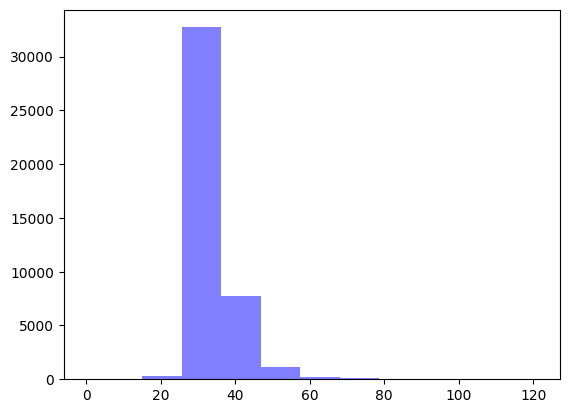

In [29]:
rush_yards_model = train_model(X,y, 22, 130, n_hidden = 1000, epochs=10) # 2.90, 

In [30]:
rush_yards_model = rush_yards_model.to('cpu')

In [31]:
model_path = "models/run_yards_gained.pt"
torch.save(rush_yards_model.state_dict(), model_path)


feature_config = {
    'rush_yard_cols':rush_yards_cols
}
feature_config

update_config(feature_config)

In [54]:
test = rushes.loc[rushes.yardline_100==5][rush_yards_cols+ ['yards_shifted']]
test

,yardline_100,down,goal_to_go,ydstogo,posteam_score,defteam_score,score_differential,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,...,temp,spread_line,total_line,carries_roll,rushing_yards_roll,fantasy_points_ppr_roll,yards_per_carry_roll,rushing_yards_team_roll,rushing_yards_opp_roll,yards_shifted
166,5.0,3.0,0,4.0,0.0,0.0,0.0,269.0,1169.0,2969.0,...,64.0,5.5,40.5,16.000000,62.000000,6.200000,3.875000,89.000000,89.000000,32.0
307,5.0,2.0,0,4.0,17.0,14.0,3.0,190.0,190.0,190.0,...,87.0,-2.5,37.0,22.000000,75.000000,11.800000,3.409091,119.000000,119.000000,33.0
416,5.0,2.0,1,5.0,0.0,0.0,0.0,632.0,1532.0,3332.0,...,75.0,-6.5,44.5,5.000000,22.000000,21.080000,4.400000,101.000000,101.000000,34.0
740,5.0,2.0,1,5.0,0.0,0.0,0.0,160.0,1060.0,2860.0,...,78.0,-4.0,45.5,19.000000,75.000000,6.700000,3.947368,109.000000,109.000000,32.0
1013,5.0,2.0,0,4.0,7.0,10.0,-3.0,614.0,614.0,2414.0,...,50.0,-7.0,41.0,9.750000,34.333333,4.308333,4.180373,69.500000,28.000000,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211687,5.0,2.0,1,5.0,0.0,0.0,0.0,592.0,1492.0,3292.0,...,50.0,3.0,51.0,4.983394,33.303888,20.009290,4.370067,112.571429,90.428571,35.0
211847,5.0,3.0,1,5.0,14.0,6.0,8.0,144.0,1044.0,1044.0,...,50.0,-7.0,50.5,13.285641,78.551508,17.572916,6.174134,150.571429,132.285714,35.0
212084,5.0,1.0,1,5.0,10.0,6.0,4.0,827.0,827.0,827.0,...,36.0,3.5,36.5,8.464598,44.788316,6.142742,5.420636,69.571429,92.285714,33.0
212090,5.0,1.0,1,5.0,6.0,18.0,-12.0,509.0,509.0,509.0,...,36.0,-3.5,36.5,1.304678,5.176026,1.031306,5.184281,139.000000,104.142857,28.0


<Axes: >

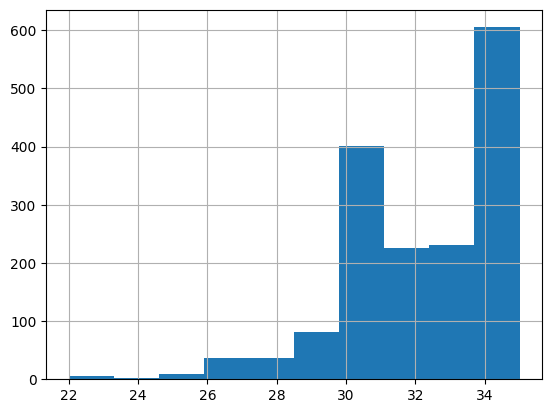

In [55]:
test['yards_shifted'].hist()

torch.Size([1, 20])
torch.Size([130])
torch.Size([1, 20])
torch.Size([130])
torch.Size([1, 20])
torch.Size([130])
torch.Size([1, 20])
torch.Size([130])
torch.Size([1, 20])
torch.Size([130])


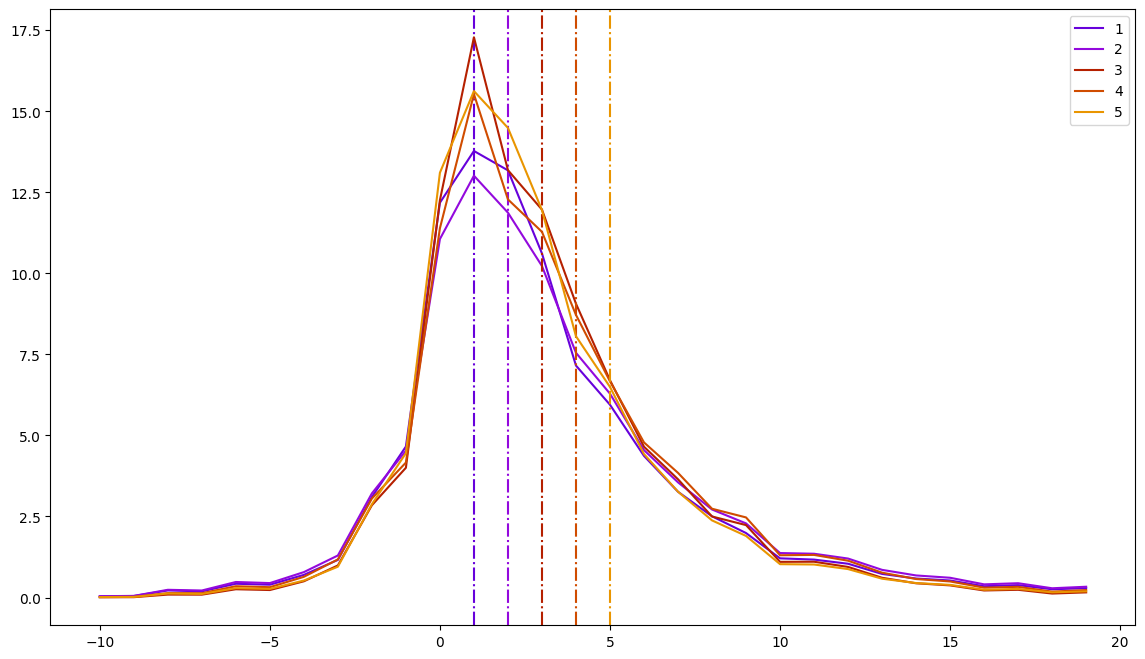

In [57]:
colormap = cm.gnuplot
plt.figure(figsize=(14, 8))
num_yardlines = 6
for yardline in range(1,num_yardlines):

    color = colormap(yardline / num_yardlines) 
    down=1
    test = rushes.loc[rushes.yardline_100==yardline]
    xx = torch.Tensor(test[rush_yards_cols].sample(1).values)
    print(xx.shape)
    with torch.no_grad():
        xy = rush_yards_model(xx)
        xy = (100 * F.softmax(xy,dim=1))[0]
        print(xy.shape)
        x_range = range(-10,20)
    plt.axvline(yardline, color=color, linestyle='-.')
    plt.plot(x_range, xy[20:50], label=yardline, color=color)

plt.legend()

In [59]:
test = rushes.loc[rushes.yardline_100==45].sample(1)
xx = torch.Tensor(test[rush_yards_cols].values)
xy = xy = torch.Tensor(test['yards_shifted'].values)

3.928


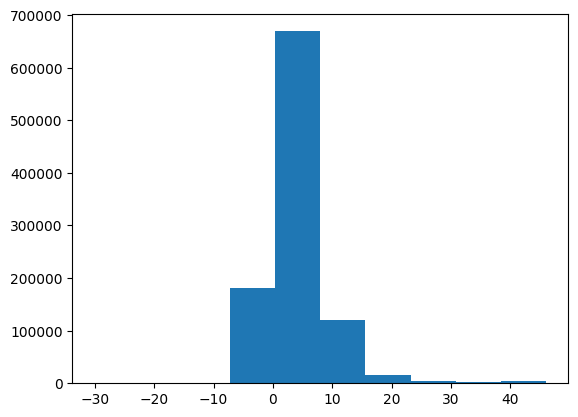

In [60]:
a = [('yardline_100', 46), ('down', 2), ('goal_to_go', 0), ('ydstogo', 4), ('posteam_score', 0), ('defteam_score', 7), ('score_differential', -7), ('quarter_seconds_remaining', 519), ('half_seconds_remaining', 1419), ('game_seconds_remaining', 3219), ('wind', 2), ('temp', 71), ('spread_line', -2.5), ('total_line', 42.5), ('carries_roll', 16.671224899970426), ('rushing_yards_roll', 64.09064072247367), ('fantasy_points_ppr_roll', 11.077405732067295), ('yards_per_carry_roll', 4.553092504894218), ('rushing_yards_team_roll', 112.71428571428572), ('rushing_yards_opp_roll', 102.57142857142856)]
monty = torch.tensor([[t[1] for t in a]])


res = rush_yards_model(monty)
res = F.softmax(res,dim=1)[0]
samples = torch.clamp( torch.multinomial(res,1000000,replacement=True),max=76) - 30
avg = round(samples.double().mean().item(), 3)
plt.hist(samples)
print(avg)

In [61]:
[print(a,b) for a,b in zip(list(xx[0]), rush_yards_cols)]
xy

tensor(45.) yardline_100
tensor(2.) down
tensor(0.) goal_to_go
tensor(1.) ydstogo
tensor(10.) posteam_score
tensor(14.) defteam_score
tensor(-4.) score_differential
tensor(33.) quarter_seconds_remaining
tensor(33.) half_seconds_remaining
tensor(1833.) game_seconds_remaining
tensor(8.) wind
tensor(50.) temp
tensor(7.) spread_line
tensor(41.) total_line
tensor(5.2700) carries_roll
tensor(25.0553) rushing_yards_roll
tensor(3.8345) fantasy_points_ppr_roll
tensor(6.2818) yards_per_carry_roll
tensor(108.4286) rushing_yards_team_roll
tensor(166.5714) rushing_yards_opp_roll


tensor([34.])

In [62]:
xx[0][12] #127

tensor(7.)

opp_yards: -15 4.87
opp_yards: -13 4.855
opp_yards: -11 4.864
opp_yards: -9 4.861
opp_yards: -7 4.858
opp_yards: -5 4.871
opp_yards: -3 4.869
opp_yards: -1 4.869
opp_yards: 1 4.873
opp_yards: 3 4.869
opp_yards: 5 4.871
opp_yards: 7 4.858
opp_yards: 9 4.862
opp_yards: 11 4.865
opp_yards: 13 4.859


(array([5.50000e+02, 5.90000e+02, 3.53800e+03, 2.94040e+05, 5.67094e+05,
        8.98810e+04, 2.17690e+04, 8.12000e+03, 4.80200e+03, 9.61600e+03]),
 array([ 0.,  8., 16., 24., 32., 40., 48., 56., 64., 72., 80.]),
 <BarContainer object of 10 artists>)

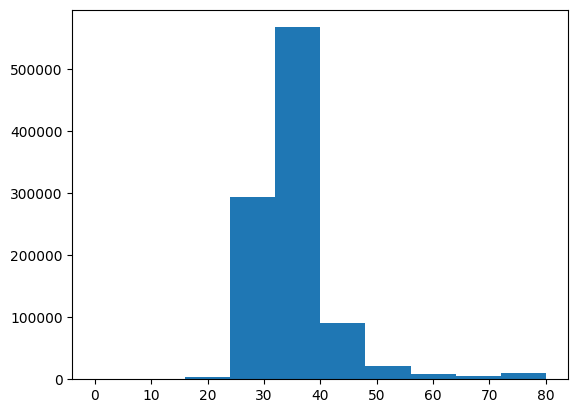

In [63]:
for ypc in range(-15, 15, 2):
    xx[0][12] = torch.tensor(5)
    res = rush_yards_model(xx)
    res = F.softmax(res,dim=1)[0]
    samples = torch.clamp( torch.multinomial(res,1000000,replacement=True),max=80)
    avg = round(samples.double().mean().item()-30, 3)
    print(f'opp_yards: {ypc}',avg) # 3.34
plt.hist(samples)

In [64]:
samples.double().min()

tensor(0., dtype=torch.float64)

<Axes: >

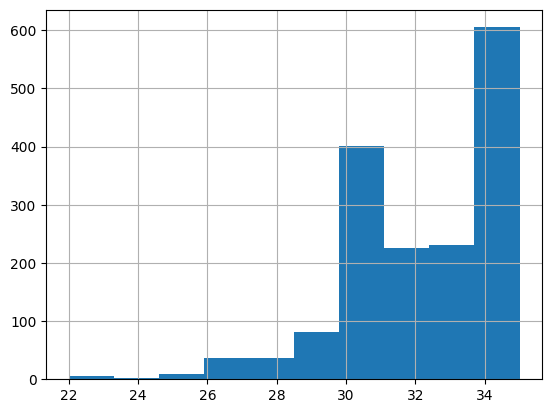

In [65]:
rushes.loc[rushes.yardline_100==5]['yards_shifted'].hist()

In [89]:
passes = pbp.loc[
        (pbp['pass']==1) & 
    (pbp.pass_attempt==1) & 
    (pbp.air_yards >= -20)
    & (pbp.play_type=='pass')
].copy(deep=True).dropna(axis=1,how='all')

In [90]:
receiver_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet')[[
    "season",
    "team_name",
    "week",
    "game_type",
    "gsis_id",
    "position",
    "depth_position",
    "full_name",
    "dense_depth",
    "receptions_roll",
    "targets_roll",
    "receiving_yards_roll",
    "receiving_tds_roll",
    "receiving_air_yards_roll",
    "receiving_yards_after_catch_roll",
    "receiving_first_downs_roll",
    "target_share_roll",
    "air_yards_share_roll",
    "fantasy_points_ppr_roll",
]]

In [91]:
passes = passes.merge(
    receiver_stats,
    left_on=["posteam", "season", "week", "receiver_player_id"],
    right_on=["team_name", "season", "week", "gsis_id"],
)
passes


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,receptions_roll,targets_roll,receiving_yards_roll,receiving_tds_roll,receiving_air_yards_roll,receiving_yards_after_catch_roll,receiving_first_downs_roll,target_share_roll,air_yards_share_roll,fantasy_points_ppr_roll
0,58.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000,0.000000,1.000000
1,103.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,3.000000,15.000000,43.000000,1.000000,226.000000,11.000000,2.000000,0.375000,0.548544,13.300000
2,132.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,4.000000,4.000000,40.000000,0.000000,3.000000,37.000000,2.000000,0.100000,0.007282,15.400000
3,177.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,7.000000,7.000000,132.000000,0.000000,72.000000,60.000000,6.000000,0.175000,0.174757,20.200001
4,254.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,LA,home,ARI,...,10.000000,16.000000,119.000000,0.000000,162.000000,29.000000,5.000000,0.290909,0.429708,21.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275338,3812.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,HOU,home,TEN,...,3.595031,5.547692,38.746028,0.006583,47.391892,15.318911,1.831080,0.173739,0.183427,7.508952
275339,3869.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,HOU,home,TEN,...,1.947200,3.440166,30.823058,0.068518,-1.264536,32.557572,1.213335,0.109217,-0.009518,24.796145
275340,3894.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,HOU,home,TEN,...,1.947200,3.440166,30.823058,0.068518,-1.264536,32.557572,1.213335,0.109217,-0.009518,24.796145
275341,3953.0,2024_12_TEN_HOU,2024112402,HOU,TEN,REG,12,HOU,home,TEN,...,1.204704,1.874108,9.224007,0.000000,10.269402,7.783754,0.441677,0.059160,0.035902,2.127105


In [92]:
passes = passes.loc[~passes.receptions_roll.isna()].copy()
#51456 

In [93]:
team_stat_cols = [
 'completions_team_roll',
 'attempts_team_roll',
 'carries_team_roll',
 'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'completions_opp_roll',
 'attempts_opp_roll',
 'carries_opp_roll',
 'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll']

In [94]:
air_yards_cols = [
    "dense_depth",
    "receptions_roll",
    "targets_roll",
    "receiving_yards_roll",
    "receiving_tds_roll",
    "receiving_air_yards_roll",
    "receiving_yards_after_catch_roll",
    "receiving_first_downs_roll",
    "target_share_roll",
    "air_yards_share_roll",
    "fantasy_points_ppr_roll",
] + game_context_cols + ['passing_yards_opp_roll']

In [95]:
passes['target_share_roll'].isna().sum()

0

In [96]:
passes['air_yards_20'] = passes['air_yards'] + 20
data = passes[air_yards_cols + ['air_yards_20']].copy()
data = data.dropna()
X = torch.Tensor((data[air_yards_cols].values))
y = torch.tensor(data['air_yards_20'].astype(int).values, dtype=torch.long)
obs = len(X)
num_feats = len(air_yards_cols)
y.shape

torch.Size([273655])

Epoch 1/20, Loss: 0.0076
Epoch 2/20, Loss: 0.0067
Epoch 3/20, Loss: 0.0067
Epoch 4/20, Loss: 0.0067
Epoch 5/20, Loss: 0.0067
Epoch 6/20, Loss: 0.0067
Epoch 7/20, Loss: 0.0067
Epoch 8/20, Loss: 0.0067
Epoch 9/20, Loss: 0.0067
Epoch 10/20, Loss: 0.0067
Epoch 11/20, Loss: 0.0067
Epoch 12/20, Loss: 0.0067
Epoch 13/20, Loss: 0.0067
Epoch 14/20, Loss: 0.0067
Epoch 15/20, Loss: 0.0067
Epoch 16/20, Loss: 0.0067
Epoch 17/20, Loss: 0.0067
Epoch 18/20, Loss: 0.0067
Epoch 19/20, Loss: 0.0067
Epoch 20/20, Loss: 0.0067
Test Loss: 3.4000, Test Accuracy: 0.0878


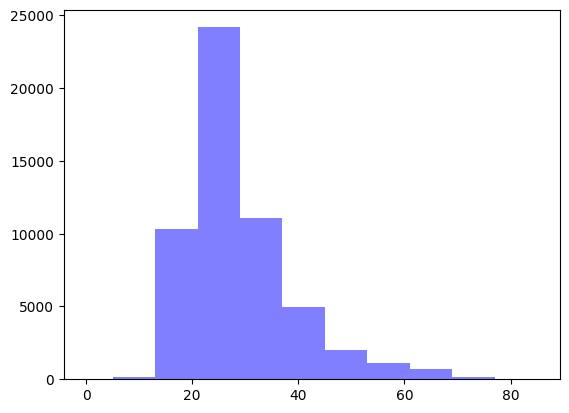

In [97]:
air_yards_model = train_model(X, y, num_feats, 119) # 3.327, 0.0865
air_yards_model = air_yards_model.to('cpu')

In [98]:
model_path = "models/air_yards.pt"
torch.save(air_yards_model.state_dict(), model_path)


feature_config = {
    'air_yards_cols':air_yards_cols,
    'air_yards_model_path': 'models/air_yards.pt',
    'run_yards_model_path': "models/run_yards_gained.pt"
}
feature_config

update_config(feature_config)

11.238636


<Axes: >

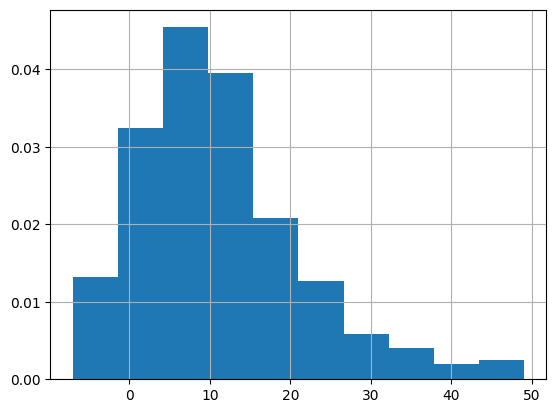

In [128]:
jj = passes.loc[passes.receiver_player_id == '00-0036322']
print(jj['air_yards'].mean())
jj['air_yards'].hist(density=True)


tensor(12.1679, dtype=torch.float64)


(array([0.00017572, 0.00473271, 0.04515679, 0.03172778, 0.0104695 ,
        0.00441791, 0.00221134, 0.00051125, 0.00016234, 0.00043464]),
 array([-20., -10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.]),
 <BarContainer object of 10 artists>)

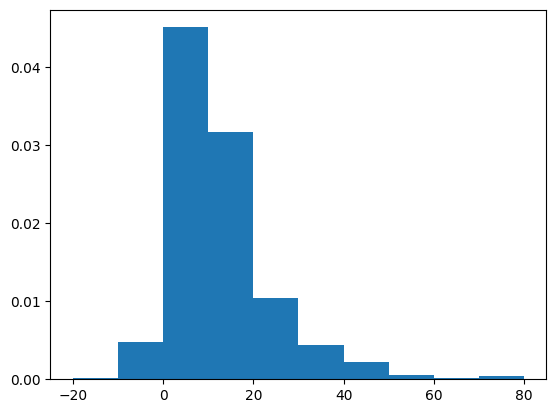

In [129]:
test_x = torch.Tensor(jj[air_yards_cols].values)
res = air_yards_model(test_x)
res = F.softmax(res,dim=1)
samples = torch.clamp( torch.multinomial(res,10000,replacement=True),max=100).reshape(-1) - 20
print(samples.double().mean())
plt.hist(samples,density=True)

In [113]:
passes[['yardline_100','yards_gained','air_yards','yards_after_catch', 'complete_pass']]

,yardline_100,yards_gained,air_yards,yards_after_catch,complete_pass
0,78.0,0.0,0.0,0.0,1.0
1,73.0,18.0,7.0,11.0,1.0
2,55.0,17.0,0.0,17.0,1.0
3,36.0,12.0,12.0,0.0,1.0
4,32.0,13.0,13.0,0.0,1.0
...,...,...,...,...,...
275338,49.0,16.0,16.0,0.0,1.0
275339,38.0,7.0,-3.0,10.0,1.0
275340,31.0,20.0,0.0,20.0,1.0
275341,21.0,11.0,-4.0,15.0,1.0


In [114]:
completions = passes.loc[passes.complete_pass==1].copy()
completions['yac_25'] = completions['yards_after_catch'] + 25

In [115]:
yac_cols = air_yards_cols + ['air_yards']
data = completions[yac_cols + ['yac_25']].copy()
data = data.dropna()
X = torch.Tensor((data[yac_cols].values))
y = torch.tensor(data['yac_25'].astype(int).values, dtype=torch.long)
obs = len(X)
air_yards_input = len(yac_cols)
X.shape

torch.Size([176802, 27])

Epoch 1/20, Loss: 0.0076
Epoch 2/20, Loss: 0.0054
Epoch 3/20, Loss: 0.0054
Epoch 4/20, Loss: 0.0054
Epoch 5/20, Loss: 0.0054
Epoch 6/20, Loss: 0.0053
Epoch 7/20, Loss: 0.0053
Epoch 8/20, Loss: 0.0053
Epoch 9/20, Loss: 0.0053
Epoch 10/20, Loss: 0.0053
Epoch 11/20, Loss: 0.0053
Epoch 12/20, Loss: 0.0053
Epoch 13/20, Loss: 0.0053
Epoch 14/20, Loss: 0.0053
Epoch 15/20, Loss: 0.0053
Epoch 16/20, Loss: 0.0053
Epoch 17/20, Loss: 0.0053
Epoch 18/20, Loss: 0.0053
Epoch 19/20, Loss: 0.0053
Epoch 20/20, Loss: 0.0053
Test Loss: 2.7272, Test Accuracy: 0.2344


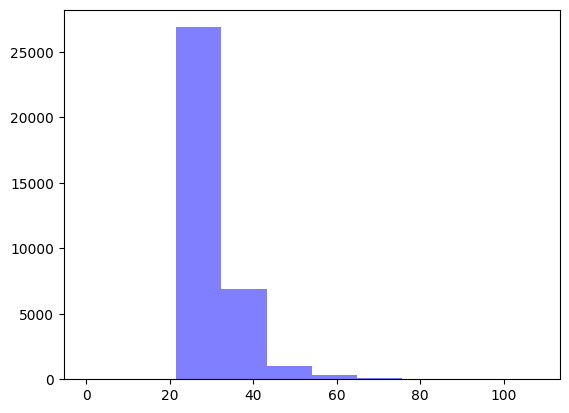

In [116]:
yac_model = train_model(X, y, 27, 125)
yac_model = yac_model.to('cpu')

(array([1.57352941e-04, 1.15588235e-04, 1.66470588e-04, 1.17352941e-04,
        1.27941176e-04, 2.33529412e-04, 1.43352941e-03, 1.32247941e-01,
        5.82991176e-02, 1.01218824e-01]),
 array([-25. , -21.6, -18.2, -14.8, -11.4,  -8. ,  -4.6,  -1.2,   2.2,
          5.6,   9. ]),
 <BarContainer object of 10 artists>)

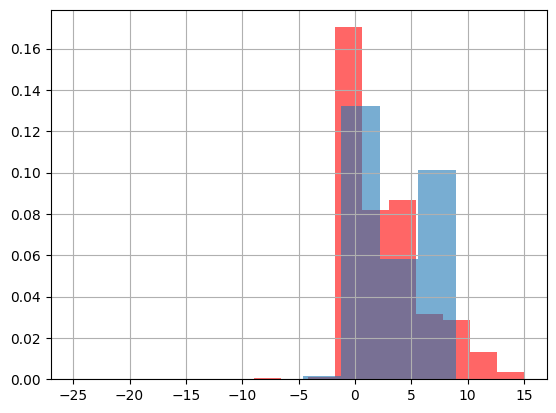

In [123]:
n = 9
ydl = data.loc[data.yardline_100==n]
(ydl['yac_25'] - 25).hist(density=True, alpha=0.6, color='r')
test_x = torch.Tensor(ydl.sample(100)[yac_cols].values)
res = yac_model(test_x)
res = F.softmax(res,dim=1)
samples = torch.clamp(torch.multinomial(res,10000,replacement=True).reshape(-1), max= (n+25)) - 25
plt.hist(samples,density=True, alpha=0.6)

In [118]:
model_path = "models/yac.pt"
torch.save(yac_model.state_dict(), model_path)


feature_config = {
    'yac_cols':yac_cols,
    'yac_path': 'models/yac.pt',
    'run_yards_model_path': "models/run_yards_gained.pt"
}
feature_config

update_config(feature_config)

In [119]:
pbp['desc'].sample(15)

196915    (4:56) (Shotgun) 28-M.Ball left tackle to DEN ...
169316    (9:17) 28-A.Peterson left guard to MIN 26 for ...
686621    (6:01) (Shotgun) 8-W.Levis pass short left to ...
83088     (1:01) 5-J.Freeman pass short left to 44-E.Lor...
263249    (3:03) (Shotgun) 5-B.Bortles pass deep right t...
163892    (4:43) 25-G.Bernard left end to CIN 29 for 3 y...
353357    (1:44) (Shotgun) 4-D.Prescott pass incomplete ...
172722    (5:51) (Shotgun) 28-M.Ball up the middle to NE...
130330    (:18) 7-C.Kaepernick kneels to MIA 42 for -1 y...
249793    (8:06) 29-J.Forsett right guard to CLE 12 for ...
672137    (11:59) (Shotgun) 18-C.Williams pass incomplet...
55833     (7:21) 6-R.Succop 40 yard field goal is GOOD, ...
137307    (9:58) 46-A.Morris left end to WAS 14 for 5 ya...
23865     (5:15) 22-M.Forte left guard to CHI 13 for 6 y...
509417    (12:14) (Shotgun) 17-P.Rivers pass short left ...
Name: desc, dtype: object

In [120]:
pbp.iloc[177294].dropna().to_dict()

{'play_id': 2570.0,
 'game_id': '2013_13_TB_CAR',
 'old_game_id': '2013120100',
 'home_team': 'CAR',
 'away_team': 'TB',
 'season_type': 'REG',
 'week': 13,
 'posteam': 'CAR',
 'posteam_type': 'home',
 'defteam': 'TB',
 'game_date': '2013-12-01',
 'quarter_seconds_remaining': 0.0,
 'half_seconds_remaining': 900.0,
 'game_seconds_remaining': 900.0,
 'game_half': 'Half2',
 'quarter_end': 1.0,
 'drive': 18.0,
 'sp': 0.0,
 'qtr': 3.0,
 'goal_to_go': 0,
 'time': '00:00',
 'yrdln': 'CAR 35',
 'ydstogo': 0.0,
 'ydsnet': 66.0,
 'desc': 'END QUARTER 3',
 'shotgun': 0.0,
 'no_huddle': 0.0,
 'qb_kneel': 0.0,
 'qb_spike': 0.0,
 'qb_scramble': 0.0,
 'home_timeouts_remaining': 3.0,
 'away_timeouts_remaining': 3.0,
 'posteam_timeouts_remaining': 3.0,
 'defteam_timeouts_remaining': 3.0,
 'total_home_score': 24.0,
 'total_away_score': 6.0,
 'posteam_score': 24.0,
 'defteam_score': 6.0,
 'score_differential': 18.0,
 'posteam_score_post': 24.0,
 'defteam_score_post': 6.0,
 'score_differential_post': 18.0